## Settings

In [ ]:
!pip install opencv-python
!pip install matplotlib

  Using cached opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.5 MB)


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import tracemalloc
import random
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score , recall_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Path to the dataset
train_path = './assets/train/'
test_path = './assets/test/'

# Feature extractor (SIFT)
sift = cv2.SIFT_create(contrastThreshold=0.01)

### Create Descriptors

In [55]:
def extract_descriptors_from_image(image_path):
    """
    Extract exactly a specified number of descriptors from an image using SIFT.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image not found or invalid: {image_path}")
    
    keypoints, descriptors = sift.detectAndCompute(image, None)
    
    if descriptors is None or len(descriptors) == 0:
        raise ValueError(f"No descriptors found in image: {image_path}")

    return descriptors

In [56]:
def collect_descriptors_all(data_path):
    """
    Collect descriptors and their corresponding labels.
    """
    all_descriptors = []
    all_labels = []
    
    classes = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
    
    num_des_tot = 0
    num_des_class_dist = []
    for i, class_name in enumerate(classes):
        class_folder = os.path.join(data_path, class_name)
        # print(f"Processing class: {class_name}")
        
        num_des_class = 0
        for image_name in os.listdir(class_folder):
            if image_name.lower().endswith(('png', 'jpg', 'jpeg')):
                image_path = os.path.join(class_folder, image_name)
                try:
                    # Extract descriptors for this image
                    descriptors = extract_descriptors_from_image(image_path)
                    
                    # Append descriptors and corresponding labels
                    all_descriptors += descriptors.tolist()
                    all_labels += [i]*len(descriptors)
                    num_des_class += len(descriptors)
                except ValueError as e:
                    print(f"Error processing {image_name}: {e}")
        num_des_tot += num_des_class
        num_des_class_dist.append(num_des_class)
    print(f'total number of descriptors: {num_des_tot}')
    print(f'number of descriptors per class: {num_des_class_dist}')
    
    # Convert to NumPy arrays
    all_descriptors = np.array(all_descriptors)
    all_labels = np.array(all_labels)
    
    return all_descriptors, all_labels, num_des_class_dist

In [57]:
def collect_descriptors_with_labels(data_path):
    """
    Collect descriptors and their corresponding labels.
    """
    all_descriptors = []
    all_labels = []
    
    classes = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

    num_des_tot = 0
    num_des_class_dist = []
    for i, class_name in enumerate(classes):
        class_folder = os.path.join(data_path, class_name)
        # print(f"Processing class: {class_name}")
        
        for image_name in os.listdir(class_folder):
            if image_name.lower().endswith(('png', 'jpg', 'jpeg')):
                image_path = os.path.join(class_folder, image_name)
                try:
                    # Extract descriptors for this image
                    descriptors = extract_descriptors_from_image(image_path)
                    all_descriptors.append(descriptors.tolist())
                    all_labels.append(i)
                except ValueError as e:
                    print(f"Error processing {image_name}: {e}")
    
    # Convert to NumPy arrays
    all_labels = np.array(all_labels)
    
    return all_descriptors, all_labels

In [58]:
# Extract descriptors and labels
descriptors_pool, labels_pool, num_des_class_dist = collect_descriptors_all(train_path)

print("Descriptor extraction completed.")

total number of descriptors: 104008
number of descriptors per class: [13465, 15119, 5421, 8680, 10758, 14686, 18524, 8025, 2550, 6780]
Descriptor extraction completed.


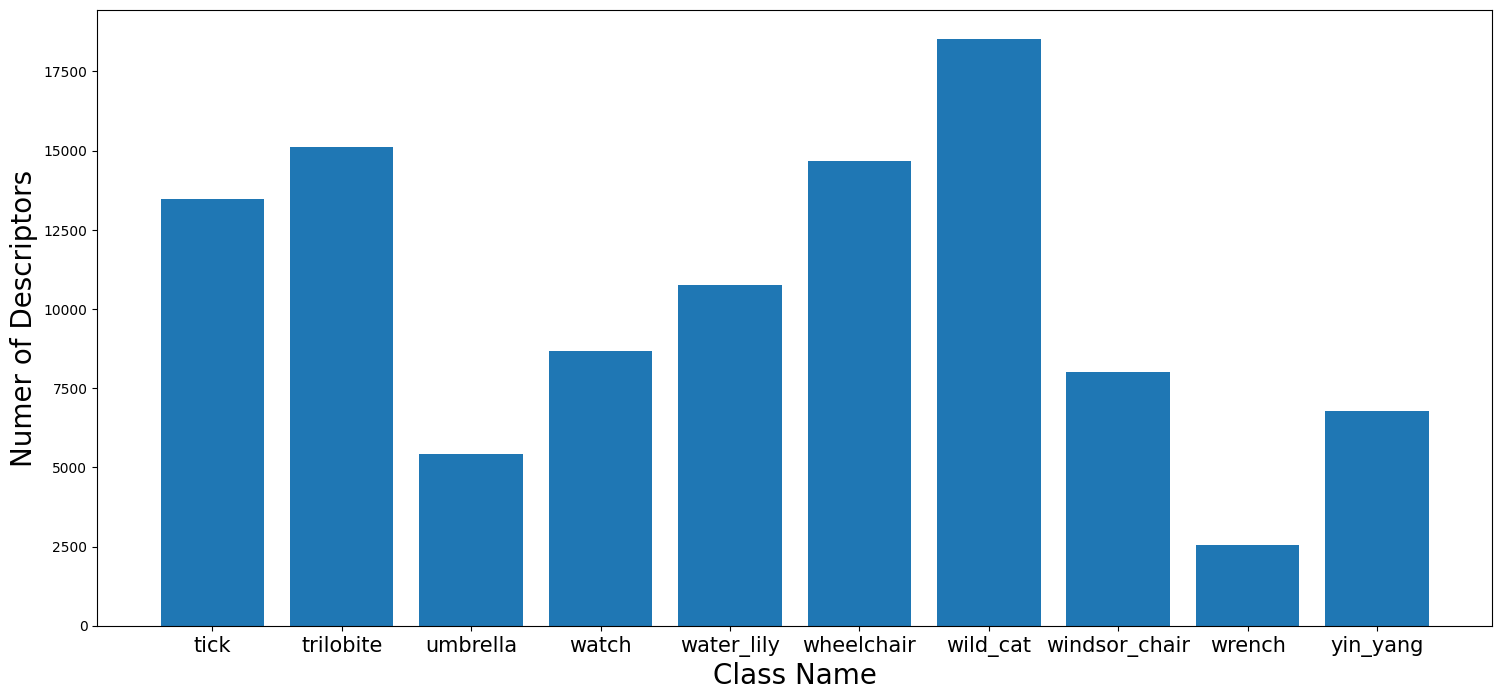

In [81]:
cls_name = ['tick', 'trilobite', 'umbrella', 'watch', 'water_lily', 'wheelchair', 'wild_cat', 'windsor_chair', 'wrench', 'yin_yang']
# Plot the histogram
plt.figure(figsize=(18, 8))
# x_axis = np.arange(len(x_train[-1]))
plt.bar(cls_name,num_des_class_dist)
# plt.title('Histogram of Train Image')
plt.xlabel('Class Name',fontsize=20)
plt.xticks(cls_name, fontsize=15)
plt.ylabel('Numer of Descriptors', fontsize=20)
plt.show()

# Q1. K-means codebook

### Construct K-Means codebook

In [91]:
# Number of clusters (k)
def Kmenas_const_times(k_list, num_iter):
    const_time = []
    avg_time = 0
    codebooks = []

    for k in k_list:
        n_codebooks = []
        for i in range(num_iter):
            start_time = time.perf_counter()
            # Initialize and fit KMeans
            kmeans = KMeans(n_clusters=k, random_state=42, verbose=0, n_init=10)
            kmeans.fit(descriptors_pool)
            
            codebook_cons_time = time.perf_counter() - start_time
            avg_time += codebook_cons_time

            n_codebooks.append(kmeans)

        const_time.append(avg_time/num_iter)
        codebooks.append(n_codebooks)
    
    return const_time, codebooks

In [92]:
k_list = [i*30 for i in range(1,6)]
num_iter = 3

const_time, codebooks = Kmenas_const_times(k_list, num_iter)

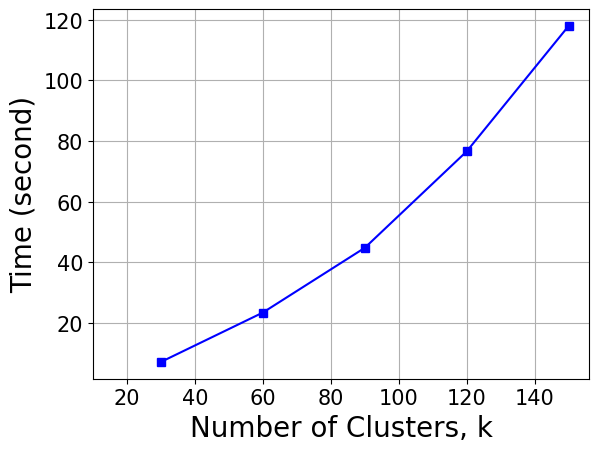

In [168]:
# Plot codebook construction time
plt.plot(k_list, const_time, marker='s', linestyle='-', color='b')
plt.xlim(left=10)
plt.xlabel('Number of Clusters, k', fontsize=20)
plt.ylabel('Time (second)', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
# plt.title('Accuracy over number of estimators')
plt.grid(True)

In [246]:
def create_bow_histogram(img_descriptors, kmeans):
    # Predict the closest cluster for each descriptor
    labels = kmeans.predict(img_descriptors)  # This gives the cluster index for each descriptor
    
    k = kmeans.n_clusters
    img_bow = np.zeros(k)

    for label in labels:
        img_bow[label] += 1

    l2_norm = np.linalg.norm(img_bow)

    # Normalize the histogram to get a normalized BoW representation
    img_bow = img_bow / np.sum(img_bow)  # Normalize to make it a probability distribution
    # img_bow = img_bow / np.linalg.norm(img_bow)  # Normalize to make it a probability distribution

    return img_bow
    # return labels

### Apply K-means codebook for train/test data

In [373]:
# Number of clusters (k)
k = 3

start_time = time.perf_counter()

# Initialize and fit KMeans
kmeans = KMeans(n_clusters=k, random_state=42, verbose=0, n_init=10)
kmeans.fit(descriptors_pool)

codebook_cons_time = time.perf_counter() - start_time

print(f'time for codebook construction time: {codebook_cons_time}')

# Access cluster centers and labels
k_means_codebook = kmeans.cluster_centers_  # Shape: (k, 128)
labels = kmeans.labels_  # Shape: (104008,)

time for codebook construction time: 0.7459056000225246


In [374]:
# Extract train descriptors and labels
train_descriptors, train_labels = collect_descriptors_with_labels(train_path)
print("Descriptor extraction completed.")

start_time = time.perf_counter()

train_bow = []
for descriptors in train_descriptors:
    image_bow = create_bow_histogram(descriptors, kmeans)
    train_bow.append(image_bow)

train_bow = np.array(train_bow)

vq_time = time.perf_counter() - start_time
print(f'vector quantization time for train data: {vq_time}')

x_train = train_bow
y_train = train_labels

Descriptor extraction completed.
vector quantization time for train data: 0.5178293000208214


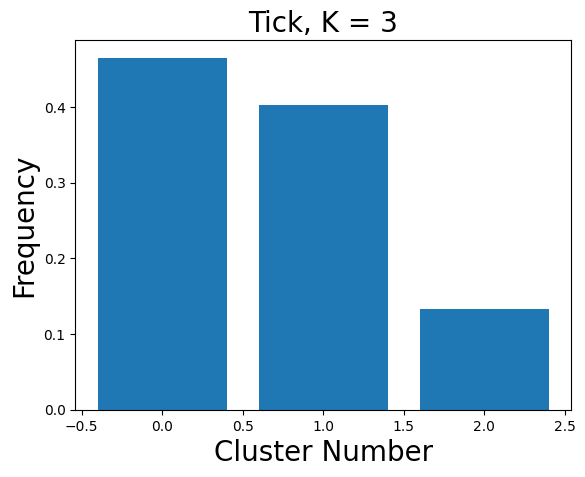

In [379]:
# Plot the histogram
x_axis = np.arange(k)
plt.bar(x_axis, x_train[0])
plt.title('Tick, K = 3', fontsize=20)
plt.xlabel('Cluster Number', fontsize=20)
# plt.xticks(x_axis)
plt.ylabel('Frequency', fontsize=20)
plt.show()

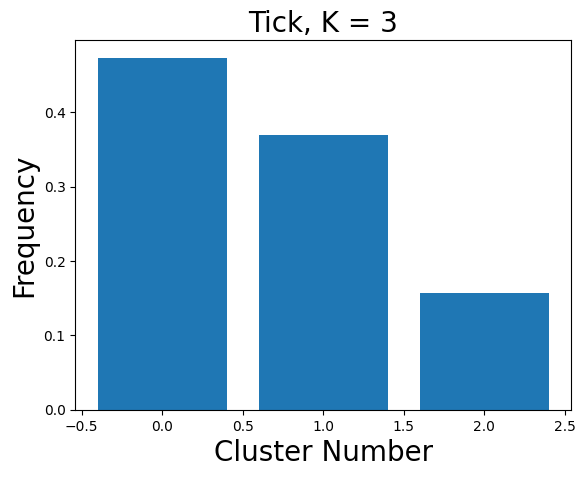

In [380]:
# Plot the histogram
x_axis = np.arange(k)
plt.bar(x_axis, x_train[1])
plt.title('Tick, K = 3', fontsize=20)
plt.xlabel('Cluster Number', fontsize=20)
# plt.xticks(x_axis)
plt.ylabel('Frequency', fontsize=20)
plt.show()

In [364]:
# Extract test descriptors and labels
test_descriptors, test_labels = collect_descriptors_with_labels(test_path)
print("Descriptor extraction completed.")

start_time = time.perf_counter()

test_bow = []
for descriptors in test_descriptors:
    image_bow = create_bow_histogram(descriptors, kmeans)
    test_bow.append(image_bow)

test_bow = np.array(test_bow)

vq_time = time.perf_counter() - start_time
print(f'vector quantization time for test data: {vq_time}')

x_test = test_bow
y_test = test_labels

Descriptor extraction completed.
vector quantization time for test data: 0.5045286000240594


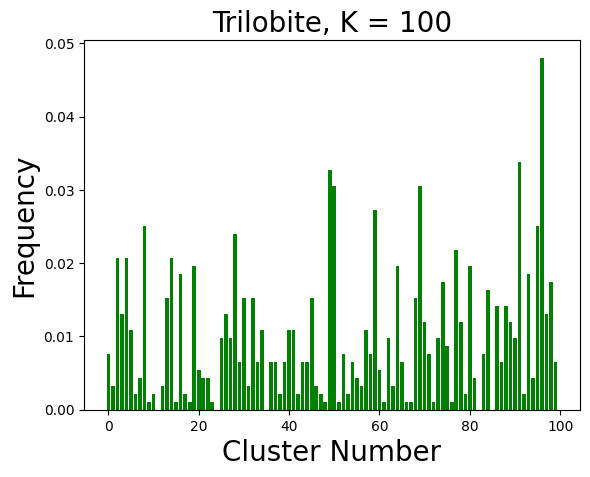

In [370]:
# Plot the histogram
x_axis = np.arange(k)
plt.bar(x_axis, x_train[29], color='g')
plt.title('Trilobite, K = 100', fontsize=20)
plt.xlabel('Cluster Number', fontsize=20)
# plt.xticks(x_axis)
plt.ylabel('Frequency', fontsize=20)
plt.show()

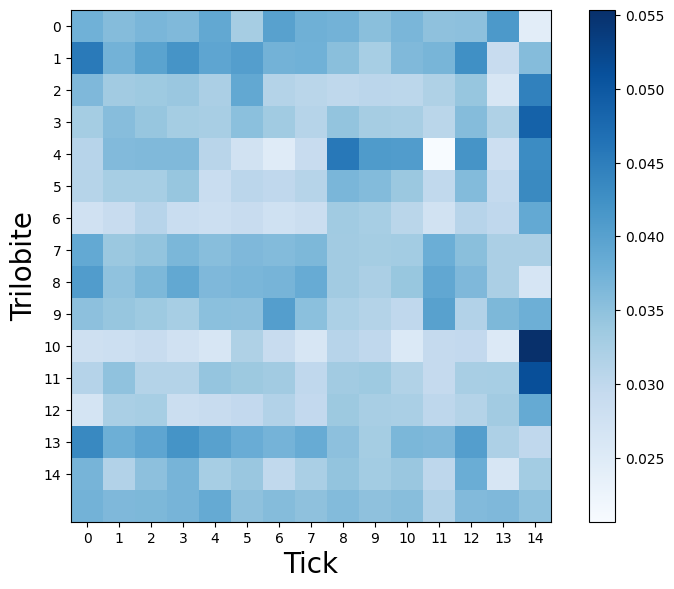

In [352]:
import numpy as np
import matplotlib.pyplot as plt

# Example: 15x15 matrix
cls_1 = x_test[0:16]
cls_2 = x_test[16:31]

matrix = cls_1 @ cls_2.T

# Create the plot
plt.figure(figsize=(8, 6))
plt.imshow(matrix, cmap='Blues')

# Add colorbar
plt.colorbar()

# Customize axes (optional)
# plt.title('Tick vs Triobite')
plt.xlabel('Tick', fontsize=20)
plt.ylabel('Trilobite', fontsize=20)

# Optionally, set ticks and labels
plt.xticks(np.arange(15))
plt.yticks(np.arange(15))

# Display the matrix
plt.tight_layout()
plt.show()


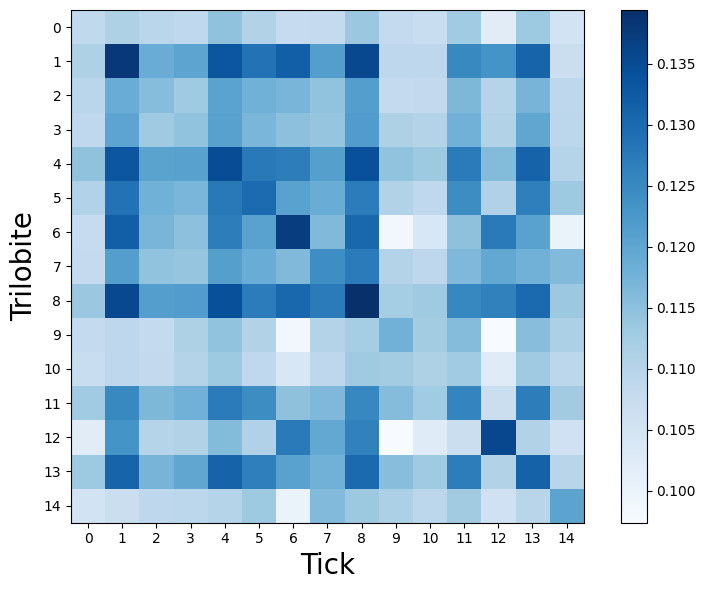

In [324]:
import numpy as np
import matplotlib.pyplot as plt

# Example: 15x15 matrix
cls_1 = x_test[15:30]
cls_2 = x_test[15:30]

matrix = cls_1 @ cls_2.T

# Create the plot
plt.figure(figsize=(8, 6))
plt.imshow(matrix, cmap='Blues', interpolation='nearest')

# Add colorbar
plt.colorbar()

# Customize axes (optional)
# plt.title('Tick vs Triobite')
plt.xlabel('Tick', fontsize=20)
plt.ylabel('Trilobite', fontsize=20)

# Optionally, set ticks and labels
plt.xticks(np.arange(15))
plt.yticks(np.arange(15))

# Display the matrix
plt.tight_layout()
plt.show()


### Check vector quantization time

In [ ]:
const_time, codebooks = Kmenas_const_times(k_list, num_iter)

In [233]:
def vq_process_time(data_descriptors, kmeans):
    start_time = time.perf_counter()

    data_bow = []
    for descriptors in data_descriptors:
        image_bow = create_bow_histogram(descriptors, kmeans)
        data_bow.append(image_bow)
    data_bow = np.array(data_bow)
    vq_time = time.perf_counter() - start_time

    return vq_time

In [161]:
n_iter = 15
train_descriptors, train_labels = collect_descriptors_with_labels(train_path)
test_descriptors, test_labels = collect_descriptors_with_labels(test_path)

avg_vq_time_list = []

for codebook in codebooks:
    codebook = codebook[0]
    avg_vq_time = 0
    for i in range(n_iter):
        vq_time = vq_process_time(test_descriptors, codebook)
        avg_vq_time += vq_time
    avg_vq_time_list.append(avg_vq_time/n_iter)

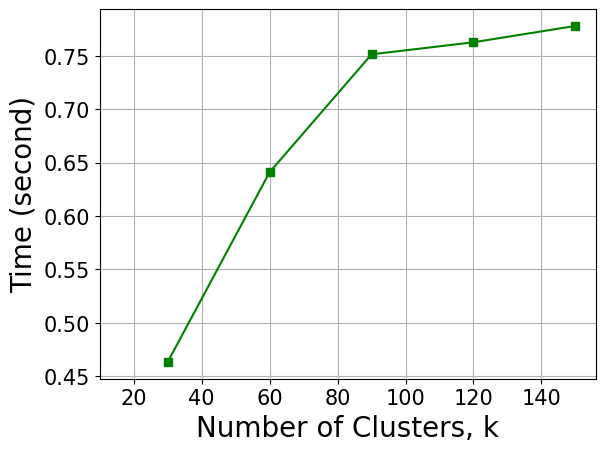

In [166]:
# Plot accuracy on the first subplot
plt.plot(k_list, avg_vq_time_list, label='vector quantization time', marker='s', linestyle='-', color='g')
plt.xlim(left=10)
plt.xlabel('Number of Clusters, k', fontsize=20)
plt.ylabel('Time (second)', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
# plt.title('Accuracy over number of estimators')
# plt.legend(fontsize=15)
plt.grid(True)

# Q2. RF classifier

In [ ]:
def RF_classification(x_train, y_train, x_test, n_estimators=30, max_depth=10, bootstrap=True, random_state=None, max_samples=0.7, max_features="sqrt", criterion='entropy'):
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, bootstrap=bootstrap, random_state=random_state, max_samples=max_samples, max_features=max_features, criterion=criterion)
    # Train ----------------------------------------------------------
    tracemalloc.start() 
    start_time = time.perf_counter()
    
    rf_clf.fit(x_train, y_train.ravel())
    
    train_time = time.perf_counter() - start_time
    current, train_peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    y_train_pred = rf_clf.predict(x_train)

    # Test ----------------------------------------------------------
    tracemalloc.start() 
    start_time = time.perf_counter()

    y_test_pred = rf_clf.predict(x_test)

    test_time = time.perf_counter()- start_time
    current, test_peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Retrieve the maximum depth of each tree in the forest
    tree_depths = [estimator.tree_.max_depth for estimator in rf_clf.estimators_]
    max_tree_depth = max(tree_depths)

    return y_train_pred, y_test_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth

### Weak learner: Axis-aligned test

In [256]:
y_train_pred, y_test_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth = RF_classification(x_train, y_train, x_test, n_estimators=150, max_depth=10, bootstrap=True, random_state=None, max_samples=0.7, max_features="sqrt", criterion='entropy')

train_accuracy = accuracy_score(y_train.T, y_train_pred)
test_accuracy = accuracy_score(y_test.T, y_test_pred)
test_precision = precision_score(y_test.T, y_test_pred, average= "macro", zero_division=0)
test_recall = recall_score(y_test.T, y_test_pred, average= "macro", zero_division=0)

print(f'train time: {train_time}')
print(f'train accuracy: {train_accuracy}')
print('\n')

print(f'test time: {test_time}')
print(f'test_accuracy: {test_accuracy}')
print('\n')

print(f'test_precision: {test_precision}')
print(f'test_recall: {test_recall}')
print('\n')

print(f'max tree depth: {max_tree_depth}')

train time: 0.820372199988924
train accuracy: 1.0


test time: 0.0088246000232175
test_accuracy: 0.36


test_precision: 0.34436965811965814
test_recall: 0.36000000000000004


max tree depth: 10


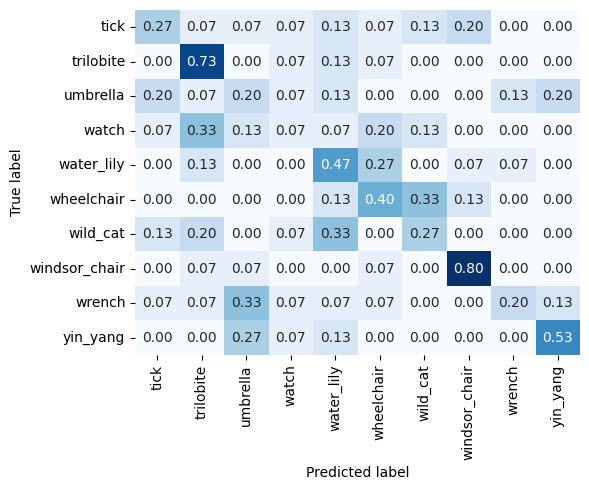

In [ ]:
def plot_confusion_matrix_seaborn(cm, labels):
    plt.figure(figsize=(6, 5))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)
    # sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False)
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)
    # plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

cm = confusion_matrix(y_test.T, y_test_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix_seaborn(cm_percentage, cls_name)


### Weak learner: Two-pixel test

In [72]:
def create_two_pixel_features(x_train, x_test, n_pairs=None, random_seed=None):
    x_combined = np.concatenate([x_train, x_test], axis=1)

    n_features, n_samples = x_combined.shape

    # Set random seed if provided
    if random_seed is not None:
        random.seed(random_seed)

    # Generate all unique pairs of features where i != j
    feature_pairs = [(i, j) for i in range(n_features) for j in range(i + 1, n_features)]

    # If n_pairs is specified, randomly select a subset of feature pairs
    if n_pairs is not None and n_pairs < len(feature_pairs):
        feature_pairs = random.sample(feature_pairs, n_pairs)
    
    # Initialize a new features matrix for pairwise differences
    new_features = np.zeros((len(feature_pairs), n_samples))

    # Fill in the new features with pairwise differences
    for idx, (i, j) in enumerate(feature_pairs):
        new_features[idx, :] = x_combined[i, :] - x_combined[j, :]

    x_train_2pix = new_features[:, :x_train.shape[1]]
    x_test_2pix = new_features[:, x_train.shape[1]:]

    return x_train_2pix.T, x_test_2pix.T

In [16]:
n_pairs = x_train.shape[1]
# n_pairs = 100
x_train_2pix, x_test_2pix = create_two_pixel_features(x_train.T, x_test.T, n_pairs=n_pairs, random_seed=0)
y_train_pred, y_test_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth = RF_classification(x_train_2pix, y_train, x_test_2pix, n_estimators=30, max_depth=10, bootstrap=True, random_state=None, max_samples=0.7, max_features="sqrt", criterion='entropy')

train_accuracy = accuracy_score(y_train.T, y_train_pred)
test_accuracy = accuracy_score(y_test.T, y_test_pred)
test_precision = precision_score(y_test.T, y_test_pred, average= "macro", zero_division=0)
test_recall = recall_score(y_test.T, y_test_pred, average= "macro", zero_division=0)

print(f'train time: {train_time}')
print(f'train accuracy: {train_accuracy}')
print('\n')

print(f'test time: {test_time}')
print(f'test_accuracy: {test_accuracy}')
print('\n')

print(f'test_precision: {test_precision}')
print(f'test_recall: {test_recall}')
print('\n')

print(f'max tree depth: {max_tree_depth}')

train time: 0.08017654716968536
train accuracy: 0.9866666666666667


test time: 0.0036899838596582413
test_accuracy: 0.30666666666666664


test_precision: 0.28711344211344214
test_recall: 0.30666666666666664


max tree depth: 10


### Impcact of vocabulary size on classification accuracy

In [ ]:
# k_list = [i*30 for i in range(1,6)]
# num_iter = 3

# const_time, codebooks = Kmenas_const_times(k_list, num_iter)

In [93]:
def vq_process(data_descriptors, kmeans):
    data_bow = []
    for descriptors in data_descriptors:
        image_bow = create_bow_histogram(descriptors, kmeans)
        data_bow.append(image_bow)
    data_bow = np.array(data_bow)

    return data_bow

In [124]:
def avg_accuracy(train_descriptors, test_descriptors, n_iter, codebooks, codebook_num):
    test_accuracy_list = []
    for n_codebook in codebooks:
        codebook = n_codebook[codebook_num]
        test_accuracy = 0
        for i in range(n_iter):
            x_train = vq_process(train_descriptors, codebook)
            y_train = train_labels

            x_test = vq_process(test_descriptors, codebook)
            y_test = test_labels

            y_train_pred, y_test_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth = RF_classification(x_train, y_train, x_test, n_estimators=30, max_depth=5, bootstrap=True, random_state=None, max_samples=0.7, max_features="sqrt", criterion='entropy')
            test_accuracy += accuracy_score(y_test.T, y_test_pred)
        
        test_accuracy_list.append(test_accuracy/(num_iter*num_iter))

    return test_accuracy_list

In [142]:
test_accuracy_list = []
train_descriptors, train_labels = collect_descriptors_with_labels(train_path)
test_descriptors, test_labels = collect_descriptors_with_labels(test_path)
n_iter = 10

codebook_num = 0
test_accuracy_list_1 = avg_accuracy(train_descriptors, test_descriptors, n_iter, codebooks, codebook_num)

codebook_num = 1
test_accuracy_list_2 = avg_accuracy(train_descriptors, test_descriptors, n_iter, codebooks, codebook_num)

codebook_num = 2
test_accuracy_list_3 =avg_accuracy(train_descriptors, test_descriptors, n_iter, codebooks, codebook_num)

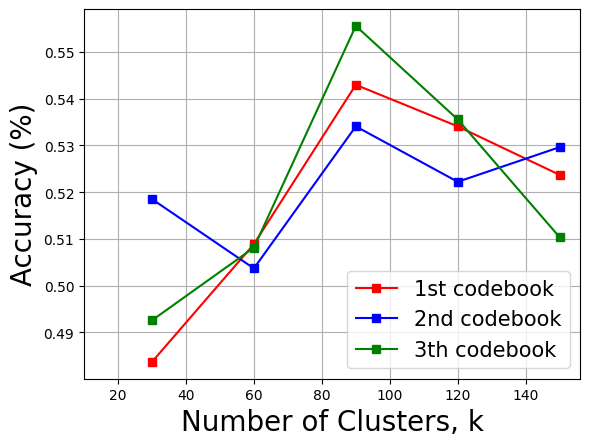

In [150]:
# Plot accuracy on the first subplot
plt.plot(k_list, test_accuracy_list_1, label='1st codebook', marker='s', linestyle='-', color='r')
plt.plot(k_list, test_accuracy_list_2, label='2nd codebook', marker='s', linestyle='-', color='b')
plt.plot(k_list, test_accuracy_list_3, label='3th codebook', marker='s', linestyle='-', color='g')
plt.xlim(left=10)
plt.xlabel('Number of Clusters, k', fontsize=20)
plt.ylabel('Accuracy (%)', fontsize=20)
# plt.title('Accuracy over number of estimators')
plt.legend(fontsize=15)
plt.grid(True)